# Functional Data Analysis with Monovariate Prediction
This notebook demonstrates the process of conducting a functional data analysis with a focus on monovariate prediction. It outlines the goal of the notebook, the dataset being used, and the main steps that will be taken.

## 1. Setting Up the Environment
The following cells set up the environment by loading necessary libraries and defining the path to the simulation file.

In [16]:
# @__DIR__ is the directory of the current file
# We need to go up to the parent directory to find the project root
project_root = dirname(dirname(@__DIR__))


include(joinpath(project_root, "setup", "init_env.jl"))
set_R_lib_path(project_root)
using Plots
using Statistics

  Activating project at `c:\Users\User\Documents\repos\TESI\tesi_data\progetto_s_on_f.md\b_spline\functional-data-regression-mip`


## 2. Define simulation data
Here we load the data required for the simulation and run the R simulation script to prepare the data for analysis.

**NOTICE** -> The seed should be the same for both the training and the test datasets, otherwise the data distribution will be different. 
This is very important specifically in the "Paper simulation" where the predictors shape depends on the coefficients a1,...f3 extracted from Uniform and Normal distributions.  

In [55]:
include(joinpath(project_root, "simulations", "simulation.jl"))


simulation_name = "5_predictors"
simulation_settings_file = "default"

measurements = 100
basis_functions = 6
params_train = (
    observations = 450,
    measurements = measurements,
    basis_functions = basis_functions,
    noise_snr = [100,1000],
    seed = 1
)

params_test = (
    observations = 200,
    measurements = measurements,
    basis_functions = basis_functions,
    noise_snr = [100,1000],
    seed = 300
)



(observations = 200, measurements = 100, basis_functions = 6, noise_snr = [100, 1000], seed = 300)

## 3. Run the simulation and save the data

In [56]:

# Note: Use ... to unpack NamedTuple into keyword arguments
output = load_simulation_data(simulation_name, simulation_settings_file, project_root; params_train...)

output_test = load_simulation_data(simulation_name, simulation_settings_file, project_root; params_test...)


# Grab the outputs from the R script

predictors = Int(output[:predictors])
true_predictors = output[:true_predictors]
intercept = output[:intercept]
observations = Int(output[:observations])

# betas and basis
beta_matrix  = output[:B]
basis_objs   = output[:basis_objs]
basis_values = output[:basis_values]
time_domains = output[:time_domains]

# matrixes 
U = output[:U]
X = output[:X]
Y = output[:Y]
Z = output[:Z]
J = output[:J]
W = output[:W]


X_test = output_test[:X]
Y_test = output_test[:Y]
Z_test = output_test[:Z]
J_test = output_test[:J]
W_test = output_test[:W]
beta_matrix_test  = output_test[:B]


[1] "predictors: 5"
[1] "observations: 450"
[1] "measurements: 100"
[1] "basis_functions: 6"
[1] "intercept: 0"
[1]  100 1000
[1] "predictors: 5"
[1] "observations: 200"
[1] "measurements: 100"
[1] "basis_functions: 6"
[1] "intercept: 0"
[1]  100 1000


5×6 Matrix{Float64}:
 1.47153     1.63505  2.01604   2.81354  3.55572  3.99998
 0.00530169  0.21803  0.724625  1.3561   1.92668  1.9735
 0.0         0.0      0.0       0.0      0.0      0.0
 0.0         0.0      0.0       0.0      0.0      0.0
 0.0         0.0      0.0       0.0      0.0      0.0

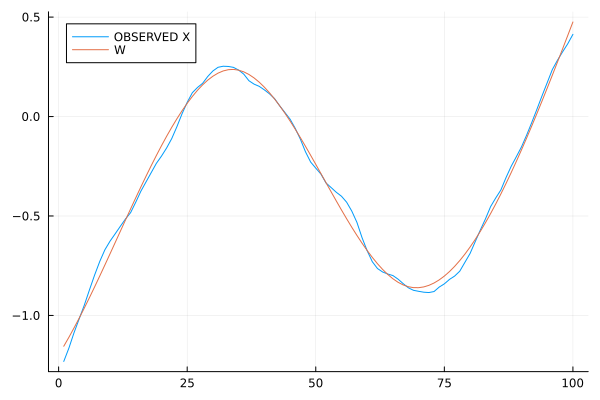

In [57]:
#  plot(U[1,1,:], label="TRUE U", legend=:topleft)
plot(X[1,1,:], label="OBSERVED X", legend=:topleft)
plot!(basis_values[1,:,:] * W[1, 1, :], label="W", legend=:topleft)


## 4. Model Execution
Run the predictive model using the prepared data.

In [78]:
model_name = "regressor_with_group_constraint" #  regressor_with_group_constraint or  simple_regressor
model_file_path = joinpath(project_root, "src", "Julia","ols_vs_mip_models", model_name *".jl")

include(model_file_path)

beta_matrix_max_values = maximum(beta_matrix, dims = 2)
beta_matrix_min_values = minimum(beta_matrix, dims = 2)

BigM = ones(predictors) .*     30000000   # or use beta_matrix_max_values
BigM_ =  ones(predictors) .*  - 30000000  # or use beta_matrix_min_values

to_predict = sum(true_predictors)
beta_star, alpha_star, groups = mip_functional_regression(Y, Z, BigM,BigM_; intercept = output[:intercept] != 0, group_limit= to_predict)




Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Set parameter TimeLimit to value 1800
Set parameter Presolve to value 0
Set parameter Heuristics to value 0
Set parameter MIPGap to value 0
Set parameter MIPFocus to value 1
Set parameter NumericFocus to value 3
Set parameter NonConvex to value 2
Set parameter OptimalityTol to value 1e-09
Set parameter IntFeasTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter TimeLimit to value 1800
Set parameter NumericFocus to value 3
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0
Set parameter MIPGap to value 0
Set parameter OptimalityTol to value 1e-09
Set parameter IntFeasTol to value 1e-09
Set parameter NonConvex to value 2
Set parameter Presolve to value 0
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 phys

([1.5971223252517968 1.6727138768940266 … 3.0166900779408845 4.417660628888912; 0.04687650387569539 0.12442530035883802 … 1.8670496473519784 2.148938859481618; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 0, [1.0, 1.0, -0.0, -0.0, -0.0])

### 5. OLS SOLUTION COMPUTATION 
I needed to reshape the matrixes because of the rappresention that I am using

In [79]:
function ols_solution(Y, Z)
    # Y: Vector of observed response variables
    # Z: Matrix of predictor variables
    
    # Reshape Z to be a matrix with dimensions (observations x predictors * basis functions)
    Z_reshaped = reshape(Z, :, size(Z, 2) * size(Z, 3))
    
    # Add a column of ones to Z for the intercept term
    Z_with_intercept = hcat(ones(size(Z_reshaped, 1)), Z_reshaped)
    
    # Calculate the OLS coefficients
    beta_hat = (Z_with_intercept' * Z_with_intercept) \ (Z_with_intercept' * Y)
    
    # Reshape beta_hat to be a matrix with dimensions (predictors x basis functions)
    beta_hat_matrix = reshape(beta_hat[2:end], size(Z, 2), size(Z, 3))
    
    return beta_hat_matrix
end



# Calculate OLS coefficients
beta_ols = ols_solution(Y, Z);



## 6. Comparing Model Results
Display the results of the model, including the estimated beta coefficients.

In [80]:
beta_matrix # true beta

5×6 Matrix{Float64}:
 1.47153     1.63505  2.01604   2.81354  3.55572  3.99998
 0.00530169  0.21803  0.724625  1.3561   1.92668  1.9735
 0.0         0.0      0.0       0.0      0.0      0.0
 0.0         0.0      0.0       0.0      0.0      0.0
 0.0         0.0      0.0       0.0      0.0      0.0

In [81]:
beta_star  # estimated beta

5×6 Matrix{Float64}:
 1.59712    1.67271   1.71934   3.28156  3.01669  4.41766
 0.0468765  0.124425  0.832238  1.32013  1.86705  2.14894
 0.0        0.0       0.0       0.0      0.0      0.0
 0.0        0.0       0.0       0.0      0.0      0.0
 0.0        0.0       0.0       0.0      0.0      0.0

In [82]:
beta_ols  # ols beta

5×6 Matrix{Float64}:
  1.5915      1.63934     1.79898    3.20101     3.06579     4.40669
  0.00798816  0.158192    0.813597   1.3459      1.82744     2.16965
 -0.0979492   0.074311   -0.0505977  0.0374171  -0.033322    0.000148694
  0.0564424   0.0333659  -0.101322   0.173175   -0.273631    0.167467
 -0.00932003  0.0366811  -0.0237881  0.0184073  -0.0114999  -0.00366942

In [83]:
groups

5-element Vector{Float64}:
  1.0
  1.0
 -0.0
 -0.0
 -0.0

In [84]:
alpha_star

0

## Visualize solutions
Plot the combined predicted curve and save the output for further analysis.

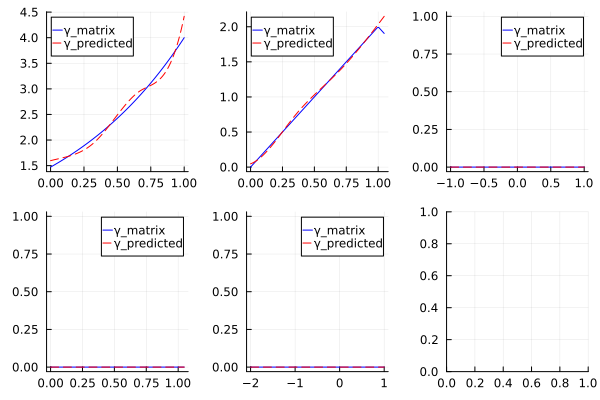

"c:\\Users\\User\\Documents\\repos\\TESI\\tesi_data\\progetto_s_on_f.md\\b_spline\\functional-data-regression-mip\\outputs\\plots\\5_predictors\\combined.png"

In [85]:
project_root = dirname( dirname(@__DIR__))
plot_file_path = joinpath(project_root, "src", "Julia","utils", "plot.jl")

include(plot_file_path)

output_folder= joinpath(project_root, "outputs", "plots", simulation_name)

beta_point_values = output[:beta_point_values]
# plot_combined_predicted_curve(beta_point_values, beta_star,basis_values, time_domains,output_folder, true; upper_bound = UB_M, lower_bound = LB_M)
plot_combined_predicted_curve(beta_point_values, beta_star,basis_values, time_domains,output_folder, true)



In [86]:

using Statistics 
using LinearAlgebra

include(joinpath(project_root, "src", "Julia", "utils", "data_analysis.jl"))

performance_metrics = compute_metrics(Y, Z, beta_matrix, beta_matrix, alpha_star, groups, predictors)


Dict{String, Float64} with 7 entries:
  "RMSE_Coefficients"  => 0.0
  "ISE_Coefficients"   => 0.0
  "MSE_Predictions"    => 0.0023348
  "R_squared"          => 0.999017
  "Adjusted_R_squared" => 0.999006
  "MSE_Coefficients"   => 0.0
  "RMSE_Predictions"   => 0.0483198

In [87]:

using Statistics 
using LinearAlgebra

include(joinpath(project_root, "src", "Julia", "utils", "data_analysis.jl"))

performance_metrics = compute_metrics(Y, Z, beta_matrix, beta_star, alpha_star, groups, predictors)


Dict{String, Float64} with 7 entries:
  "RMSE_Coefficients"  => 0.168025
  "ISE_Coefficients"   => 0.846971
  "MSE_Predictions"    => 0.00221883
  "R_squared"          => 0.999066
  "Adjusted_R_squared" => 0.999055
  "MSE_Coefficients"   => 0.0282324
  "RMSE_Predictions"   => 0.0471044

In [88]:

using Statistics 
using LinearAlgebra

include(joinpath(project_root, "src", "Julia", "utils", "data_analysis.jl"))

performance_metrics = compute_metrics(Y, Z, beta_matrix, beta_ols, alpha_star, groups, predictors)


Dict{String, Float64} with 7 entries:
  "RMSE_Coefficients"  => 0.168045
  "ISE_Coefficients"   => 0.847177
  "MSE_Predictions"    => 0.00217785
  "R_squared"          => 0.999083
  "Adjusted_R_squared" => 0.999073
  "MSE_Coefficients"   => 0.0282392
  "RMSE_Predictions"   => 0.0466674